# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br>
<br>
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br>
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

Run task **three** first to get training and testing features (from Task 3.3, notebook slovo_three)
If you have run task one yourself before you can skip first cell bellow

In [ ]:
%%capture
%run ./slovo_three.ipynb ;

In [1]:
%store -r df_records_windowed
df_records_windowed = df_records_windowed

In [2]:
import pandas as pd
import numpy as np
import time
from copy import deepcopy
import importlib, utilities.fun_five, utilities.fun_four, utilities.fun_three, utilities.fun_two, utilities.fun_one
importlib.reload(utilities.fun_five)
importlib.reload(utilities.fun_four)
importlib.reload(utilities.fun_three)
importlib.reload(utilities.fun_two)
importlib.reload(utilities.fun_one)
from utilities.fun_five import data_resample, filter_dataframe
from utilities.fun_three import reshape_dataframe
from utilities.fun_four import combine_visualize, ArrayNormalizer, GridClassifier, svm_classify, ada_classify, combine_probabilities
from utilities.fun_two import *
from utilities.fun_one import visualize

In [3]:
#splt the data into training and testing sets:

#Merge dc and act to one row (one act without dc is omitted)
records_merged = df_records_windowed[df_records_windowed.sensor_code=='dc'].merge(df_records_windowed[df_records_windowed.sensor_code=='act'], on=['subject_id', 'exercise_id', 'trial', 'window_idx'])


train_records, test_records = filter_dataframe(records_merged,ratio=0.25)

In [19]:
# 5.1

### Your code begins here ###

# Standardize the Data:
act_s = Standardizer()
act_s.fit(train_records,df_name='df_y')
train_records = act_s.transform(train_records,df_name='df_y')
test_records = act_s.transform(test_records,df_name='df_y')

dc_s = Standardizer()
dc_s.fit(train_records,df_name='df_x')
train_records = dc_s.transform(train_records,df_name='df_x')
test_records = dc_s.transform(test_records,df_name='df_x')

train_raw_records = train_records
test_raw_records = test_records

%store train_raw_records
%store test_raw_records


#ACT : -----------------
# Apply PCA:
n_components = 10
pca = PcaActApplier(n_components)
pca.fit(train_records['df_y'])
act_pca_train = pca.transform(train_records['df_y'])
act_pca_test = pca.transform(test_records['df_y'])

act_features = np.concatenate((act_pca_train[0],act_pca_train[1],act_pca_train[2],
                               np.mean(act_pca_train[0],axis=1).reshape(-1,1), np.std(act_pca_train[0],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[1],axis=1).reshape(-1,1), np.std(act_pca_train[1],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[2],axis=1).reshape(-1,1), np.std(act_pca_train[2],axis=1).reshape(-1,1),
                              ),axis=1)

act_test_features = np.concatenate((act_pca_test[0],act_pca_test[1],act_pca_test[2],
                                    np.mean(act_pca_test[0],axis=1).reshape(-1,1), np.std(act_pca_test[0],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[1],axis=1).reshape(-1,1), np.std(act_pca_test[1],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[2],axis=1).reshape(-1,1), np.std(act_pca_test[2],axis=1).reshape(-1,1),
                                   ),axis=1)
# DC -------------------
#PCA


pca_applier = PcaDcApplier(n_components)
pca_applier.fit(train_records,df_name='df_x')
pca_dc_training_records = pca_applier.transform(train_records,df_name='df_x')
pca_dc_testing_records = pca_applier.transform(test_records,df_name='df_x')

pca_dc_training_records_reshaped = deepcopy(pca_dc_training_records)
pca_dc_training_records_reshaped["df_x"] = pca_dc_training_records_reshaped["df_x"].apply(reshape_dataframe)
pca_dc_testing_records_reshaped = deepcopy(pca_dc_testing_records)
pca_dc_testing_records_reshaped["df_x"] = pca_dc_testing_records_reshaped["df_x"].apply(reshape_dataframe)

dc_features = np.concatenate(pca_dc_training_records_reshaped['df_x'].values,axis=0)
dc_test_features = np.concatenate(pca_dc_testing_records_reshaped['df_x'].values,axis=0)

labels_train = np.array(train_records.exercise_id.apply(lambda x: int(x)))
labels_test = np.array(test_records.exercise_id.apply(lambda x: int(x)))


# Normalize the data:
act_normalizer = ArrayNormalizer()
act_normalizer.fit(act_features,axis=0)
act_features = act_normalizer.transform(act_features)
act_test_features = act_normalizer.transform(act_test_features)

dc_normalizer = ArrayNormalizer()
dc_normalizer.fit(dc_features,axis=None)
dc_features = dc_normalizer.transform(dc_features)
dc_test_features = dc_normalizer.transform(dc_test_features)



### Your code ends here ###

Stored 'train_raw_records' (DataFrame)
Stored 'test_raw_records' (DataFrame)
Stored 'act_features' (ndarray)
Stored 'act_test_features' (ndarray)
Stored 'labels_train' (ndarray)
Stored 'labels_test' (ndarray)
Stored 'dc_features' (ndarray)
Stored 'dc_test_features' (ndarray)


In [6]:
# Classification
act_svm_best = svm_classify(act_features,labels_train,act_test_features)
dc_svm_best  = svm_classify(dc_features,labels_train,dc_test_features)

print(f"Act model parameters C = {act_svm_best.C} gamma = {act_svm_best.gamma}")
print(f"Dc model parameters C = {dc_svm_best.C} gamma = {dc_svm_best.gamma}")

# Get the predictions:
act_svm_pred_train = act_svm_best.predict(act_features)
act_svm_pred_test = act_svm_best.predict(act_test_features)
act_svm_proba_train = act_svm_best.predict_proba(act_features)
act_svm_proba_test = act_svm_best.predict_proba(act_test_features)

dc_svm_pred_train =  dc_svm_best.predict(dc_features)
dc_svm_pred_test =   dc_svm_best.predict(dc_test_features)
dc_svm_proba_train = dc_svm_best.predict_proba(dc_features)
dc_svm_proba_test =  dc_svm_best.predict_proba(dc_test_features)

Act model parameters C = 100.0 gamma = 1.0
Dc model parameters C = 100.0 gamma = 2.0


Accelerometer sensor used with svm to classify the subjects
Training data F1 score =  0.9914148969530595
Testing data F1 score =  0.8795017053245431


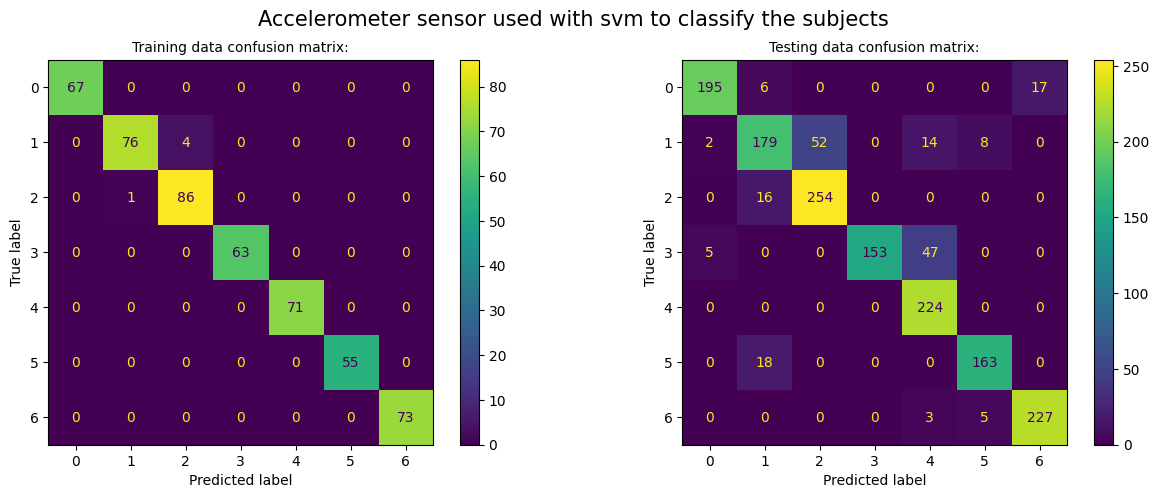

In [7]:
# Visualisation Accelerometer with svm:
visualize(act_svm_pred_train, labels_train, act_svm_pred_test, labels_test,
          main_title="Accelerometer sensor used with svm to classify the subjects")

Depth Camera sensor used with svm to classify the subjects
Training data F1 score =  1.0
Testing data F1 score =  0.9528413254989949


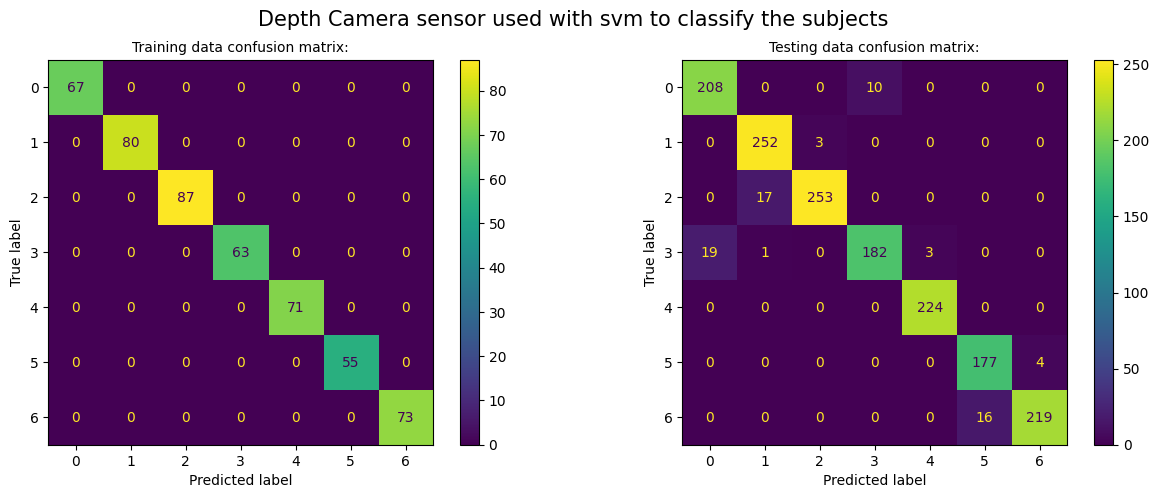

In [8]:
# Visualisation Depth Camera with svm:
visualize(dc_svm_pred_train, labels_train, dc_svm_pred_test, labels_test,
          main_title="Depth Camera sensor used with svm to classify the subjects")


In [9]:
#Combine the sensors
svm2_train, svm2_test = combine_probabilities(act_svm_proba_train, dc_svm_proba_train,
                                              act_svm_proba_test, dc_svm_proba_test)


Visualize SVM-act and SVM-dc Results :
SVM-act and SVM-dc with mean rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9739200264062592
SVM-act and SVM-dc with sum rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9739200264062592
SVM-act and SVM-dc with prod rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9746612155094623
SVM-act and SVM-dc with max rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9728315870831235
SVM-act and SVM-dc with min rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9726494938936121


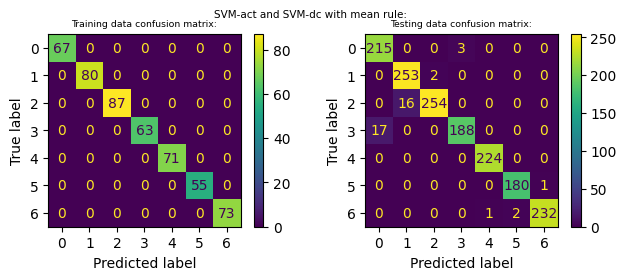

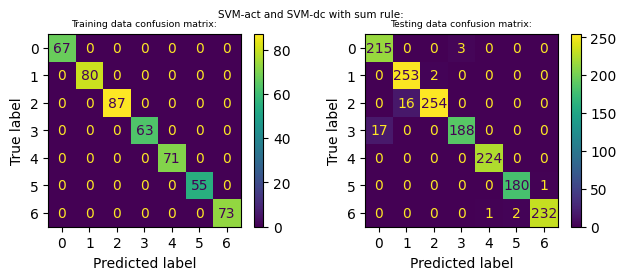

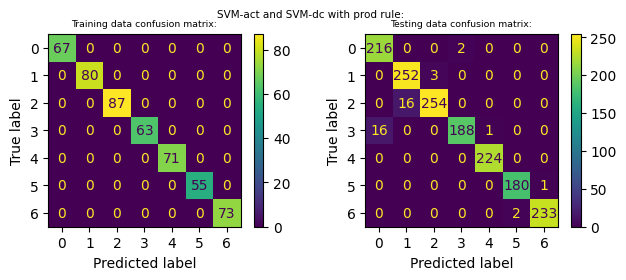

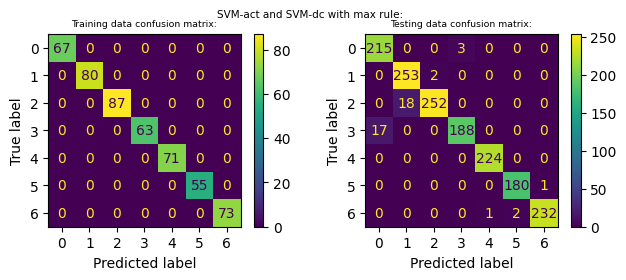

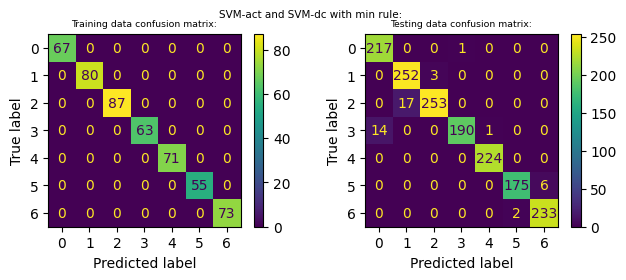

In [10]:
# Combine predictions SVM-act and SVM-dc
combine_visualize(svm2_train, labels_train, svm2_test, labels_test, "SVM-act and SVM-dc")

#### Results
Best classification result with prod rule is f1 = 0.97466

## Task 5.2 First Attempt:

Meta SVM-act and SVM-dc
Training data F1 score =  1.0
Testing data F1 score =  0.9728102727775313


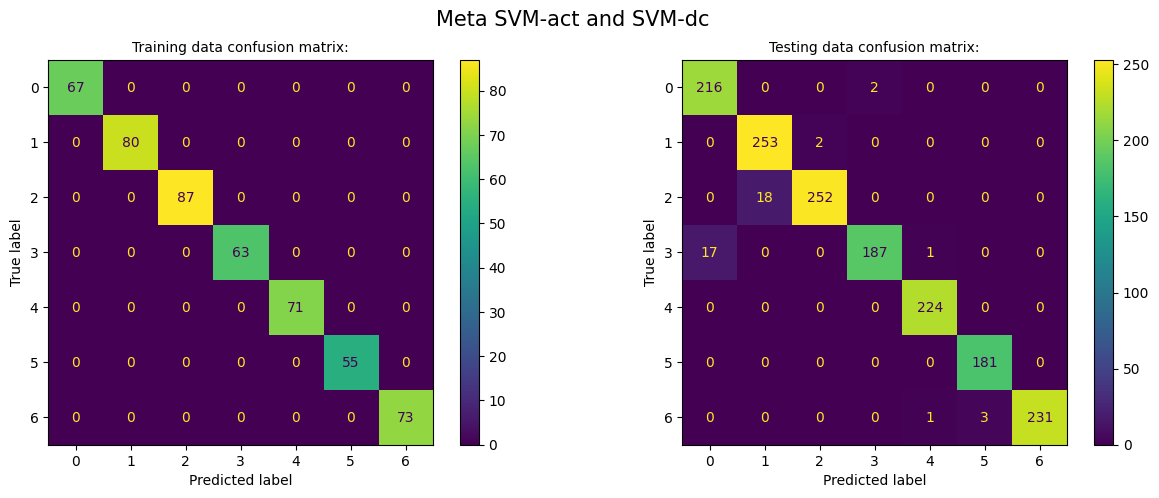

In [12]:
# Firstly We tried the metalearner:
combined_features = np.concatenate((act_svm_proba_train, dc_svm_proba_train), axis=1)
combined_features_test = np.concatenate((act_svm_proba_test, dc_svm_proba_test), axis=1)
svm_params = {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
svm_meta = svm_classify(combined_features, labels_train, combined_features_test, svm_params=svm_params)
C = svm_meta.C
gamma = svm_meta.gamma
svm_meta.fit(combined_features, labels_train)
svm_pred_train = svm_meta.predict(combined_features)
svm_pred_test = svm_meta.predict(combined_features_test)
visualize(svm_pred_train, labels_train, svm_pred_test, labels_test, "Meta SVM-act and SVM-dc")

As One can see teh meta learner also has simmilar results with f1 score = 0.9728

## Task 5.2 Second attempt:
Which is basicly the task number 5.1 but with accelereromiter PCA components reduced to 5.
It increased the F1 score on acceleromiter data and on combined data gave F1 score = 0.983
This is the best result we got in whole 5.2

In [21]:
# 5.2 take 2

### Your code begins here ###

# Standardize the Data:
act_s = Standardizer()
act_s.fit(train_records,df_name='df_y')
train_records = act_s.transform(train_records,df_name='df_y')
test_records = act_s.transform(test_records,df_name='df_y')

dc_s = Standardizer()
dc_s.fit(train_records,df_name='df_x')
train_records = dc_s.transform(train_records,df_name='df_x')
test_records = dc_s.transform(test_records,df_name='df_x')

train_raw_records = train_records
test_raw_records = test_records

%store train_raw_records
%store test_raw_records


#ACT : -----------------
# Apply PCA:
n_components = 5
pca = PcaActApplier(n_components)
pca.fit(train_records['df_y'])
act_pca_train = pca.transform(train_records['df_y'])
act_pca_test = pca.transform(test_records['df_y'])

act_features = np.concatenate((act_pca_train[0],act_pca_train[1],act_pca_train[2],
                               np.mean(act_pca_train[0],axis=1).reshape(-1,1), np.std(act_pca_train[0],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[1],axis=1).reshape(-1,1), np.std(act_pca_train[1],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[2],axis=1).reshape(-1,1), np.std(act_pca_train[2],axis=1).reshape(-1,1),
                              ),axis=1)

act_test_features = np.concatenate((act_pca_test[0],act_pca_test[1],act_pca_test[2],
                                    np.mean(act_pca_test[0],axis=1).reshape(-1,1), np.std(act_pca_test[0],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[1],axis=1).reshape(-1,1), np.std(act_pca_test[1],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[2],axis=1).reshape(-1,1), np.std(act_pca_test[2],axis=1).reshape(-1,1),
                                   ),axis=1)
# DC -------------------
#PCA

n_components = 10
pca_applier = PcaDcApplier(n_components)
pca_applier.fit(train_records,df_name='df_x')
pca_dc_training_records = pca_applier.transform(train_records,df_name='df_x')
pca_dc_testing_records = pca_applier.transform(test_records,df_name='df_x')

pca_dc_training_records_reshaped = deepcopy(pca_dc_training_records)
pca_dc_training_records_reshaped["df_x"] = pca_dc_training_records_reshaped["df_x"].apply(reshape_dataframe)
pca_dc_testing_records_reshaped = deepcopy(pca_dc_testing_records)
pca_dc_testing_records_reshaped["df_x"] = pca_dc_testing_records_reshaped["df_x"].apply(reshape_dataframe)

dc_features = np.concatenate(pca_dc_training_records_reshaped['df_x'].values,axis=0)
dc_test_features = np.concatenate(pca_dc_testing_records_reshaped['df_x'].values,axis=0)

labels_train = np.array(train_records.exercise_id.apply(lambda x: int(x)))
labels_test = np.array(test_records.exercise_id.apply(lambda x: int(x)))


# Normalize the data:
act_normalizer = ArrayNormalizer()
act_normalizer.fit(act_features,axis=0)
act_features = act_normalizer.transform(act_features)
act_test_features = act_normalizer.transform(act_test_features)

dc_normalizer = ArrayNormalizer()
dc_normalizer.fit(dc_features,axis=None)
dc_features = dc_normalizer.transform(dc_features)
dc_test_features = dc_normalizer.transform(dc_test_features)

#Save for use in other notebooks in attempt nr 3:
%store act_features
%store act_test_features
%store labels_train
%store labels_test
%store dc_features
%store dc_test_features

# Classification
act_svm_best = svm_classify(act_features,labels_train,act_test_features)
dc_svm_best  = svm_classify(dc_features,labels_train,dc_test_features)

print(f"Act model parameters C = {act_svm_best.C} gamma = {act_svm_best.gamma}")
print(f"Dc model parameters C = {dc_svm_best.C} gamma = {dc_svm_best.gamma}")

# Get the predictions:
act_svm_pred_train = act_svm_best.predict(act_features)
act_svm_pred_test = act_svm_best.predict(act_test_features)
act_svm_proba_train = act_svm_best.predict_proba(act_features)
act_svm_proba_test = act_svm_best.predict_proba(act_test_features)

dc_svm_pred_train =  dc_svm_best.predict(dc_features)
dc_svm_pred_test =   dc_svm_best.predict(dc_test_features)
dc_svm_proba_train = dc_svm_best.predict_proba(dc_features)
dc_svm_proba_test =  dc_svm_best.predict_proba(dc_test_features)

#Combine the sensors
svm2_train, svm2_test = combine_probabilities(act_svm_proba_train, dc_svm_proba_train,
                                              act_svm_proba_test, dc_svm_proba_test)

### Your code ends here ###

Stored 'train_raw_records' (DataFrame)
Stored 'test_raw_records' (DataFrame)
Stored 'act_features' (ndarray)
Stored 'act_test_features' (ndarray)
Stored 'labels_train' (ndarray)
Stored 'labels_test' (ndarray)
Stored 'dc_features' (ndarray)
Stored 'dc_test_features' (ndarray)
Act model parameters C = 100.0 gamma = 2.0
Dc model parameters C = 100.0 gamma = 2.0


Accelerometer sensor used with svm to classify the subjects
Training data F1 score =  0.991401282084288
Testing data F1 score =  0.9231270920346458


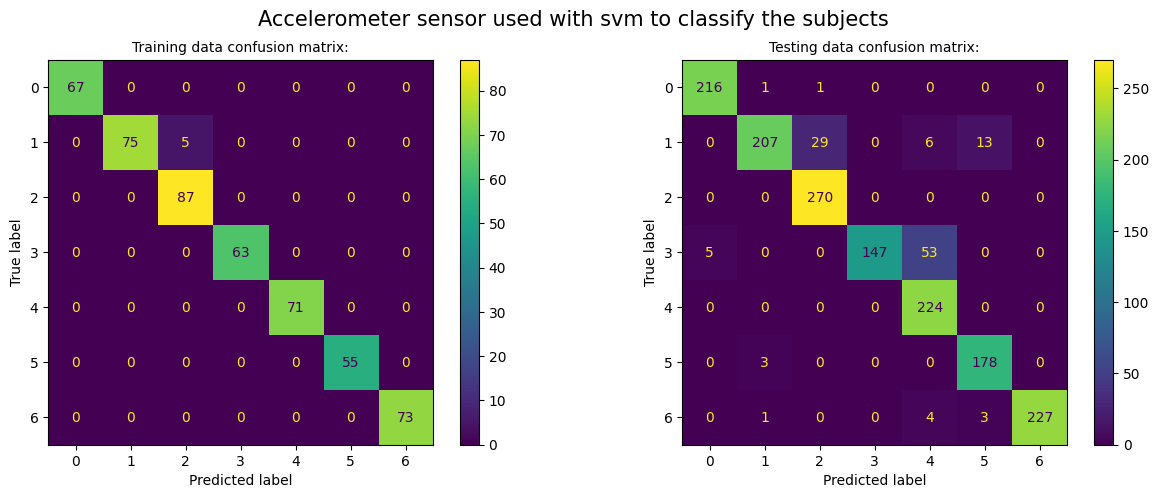

In [23]:
# Visualisation Accelerometer with svm:
visualize(act_svm_pred_train, labels_train, act_svm_pred_test, labels_test,
          main_title="Accelerometer sensor used with svm to classify the subjects")

Visualize SVM-act and SVM-dc Results :
SVM-act and SVM-dc with mean rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9774610725778652
SVM-act and SVM-dc with sum rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9774610725778652
SVM-act and SVM-dc with prod rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9799956747799949
SVM-act and SVM-dc with max rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9768227674482316
SVM-act and SVM-dc with min rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9834395871523306


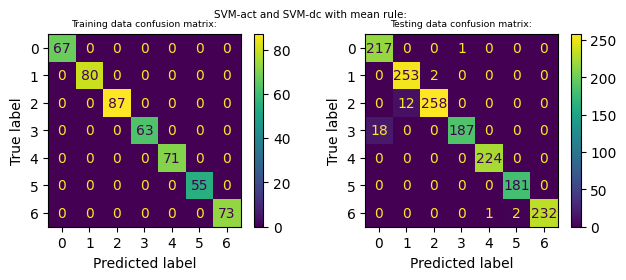

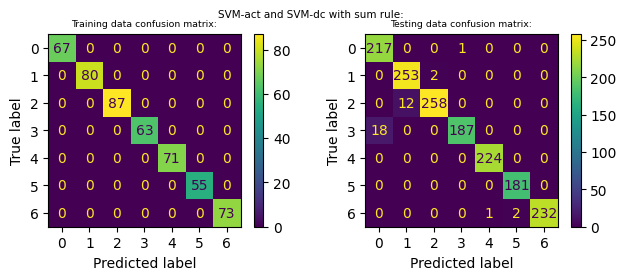

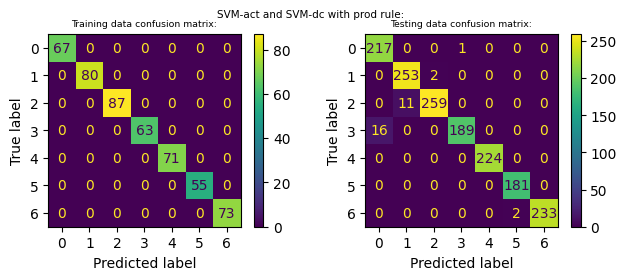

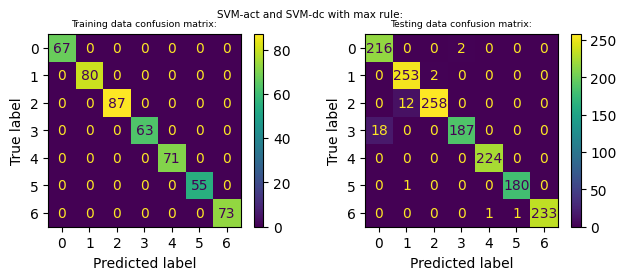

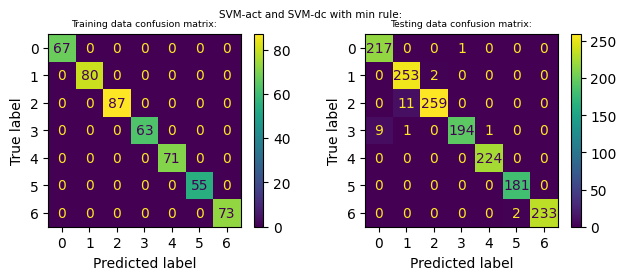

In [22]:
# Combine predictions SVM-act and SVM-dc
combine_visualize(svm2_train, labels_train, svm2_test, labels_test, "SVM-act and SVM-dc")

## Task 5.2 third attempt done in notebook slovo_mex.ipynb